In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
import pickle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

In [2]:
train_set_file = ['extracted_features.csv', #(a file is a fold)
                  'extracted_features.csv',
                  'extracted_features.csv',
                  'extracted_features.csv',
                  'extracted_features.csv'
                 ]
test_set_file = 'extracted_features.csv'

classes_list = np.array(["Glaucoma","Normal","Other"])
n_classes = 3
n_folds = 5
lw = 2

In [3]:
def calculateFprTprAuc(binary_y_test, y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(binary_y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr , tpr , roc_auc

In [4]:
def plotROC(fpr,tpr,roc_auc,title):
    #aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #interpolate all ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    #average tpr and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(classes_list[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [5]:
########## plot confusion matrix
#class_list must be numpy array
np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
    else:
         print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    plt.show()
    
    report = classification_report(y_test, y_pred, target_names=classes_list)
    print(report)
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    TNR = TN/(TN+FP) 
    
    print("Specificity")
    for i in range(n_classes):
        print("{}: {:0.2f}".format(classes_list[i], TNR[i]))

    
#     report["Glaucoma"]["specificity"] = (cm[1][0]+cm[2][0]) / (sum(cm[1])+sum(cm[2]))
#     report["Normal"]["specificity"] = (cm[0][1]+cm[2][1]) / (sum(cm[0])+sum(cm[2]))
#     report["Other"]["specificity"] = (cm[1][2]+cm[0][2]) / (sum(cm[1])+sum(cm[0]))
    


# Plot non-normalized confusion matrix


# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,title='Normalized confusion matrix')


In [6]:
#read data set
train_set_list = [pd.read_csv(file_path) for file_path in train_set_file]
test_set = pd.read_csv(test_set_file)

In [7]:
#separate X and y
X_train = [train_set.iloc[:, 2:].values for train_set in train_set_list]
y_train = [train_set.iloc[:, 1].values for train_set in train_set_list]
X_test = test_set.iloc[:, 2:].values
y_test = test_set.iloc[:, 1].values

In [8]:
# Feature Scaling Object
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#5-fold Extraction
from sklearn.model_selection import KFold
X = np.array(X_train)
y = np.array(y_train)
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

Training

In [ ]:
#training
mean_fpr = np.linspace(0, 1, 100)
interp_tpr_all_fold = []
aucs = []
bestModel = dict()
bestAUC = {"svm": 0, "rf": 0}
for i ,(train_index, val_index) in enumerate(kf.split(X)):
    
    print("----------------- fold",i+1,"-----------------")
    
    
    
    X_train = sc.fit_transform(np.concatenate(X[train_index],axis=0))
    X_val = sc.transform(X[val_index][0])
    y_train = np.concatenate(y[train_index],axis=0)
    y_val = y[val_index][0]
    
    print("training model")
    svm = OneVsRestClassifier(SVC(kernel='linear',probability=True))
    #kernel = {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    svm.fit(X_train, y_train)
    print("train finished")
    
    #print("training RF)
    #rf = RandomForestClassifier(n_estimators = 400, criterion = "gini")
    #rf.fit(X_train, y_train)
    
    #y_pred_svm = svm.predict(X_val)
    #y_pred_rf = rf.predict(X_val)
    #print("train finished")
    
    #save model
    #pickle.dump(svm, open("svm_" + (fold+1) + ".sav" , 'wb'))
    #pickle.dump(rf, open("rf" + (fold+1) + ".sav" , 'wb'))
    
    #print("validate SVM")
    
    binary_y_val = label_binarize(y_val, classes=[0, 1, 2])
    
    fpr, tpr, roc_auc = calculateFprTprAuc(binary_y_val, svm.decision_function(X_val))
    plotROC(fpr,tpr,roc_auc,"ROC curve of fold"+ str(i+1))
    
    interp_tpr = np.interp(mean_fpr, fpr["micro"], tpr["micro"])
    interp_tpr[0] = 0.0
    interp_tpr_all_fold.append(interp_tpr)
    aucs.append(roc_auc["micro"])
    
    if roc_auc["micro"] > bestAUC["svm"]:
        bestAUC["svm"] = roc_auc["micro"]
        bestModel["svm"] = svm
    

print()    
print("all fold train finished")

mean_tpr = np.mean(interp_tpr_all_fold, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(interp_tpr_all_fold, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.show()

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC of all fold')
plt.legend(loc="lower right")
plt.show()

In [14]:
X_test = sc.transform(X_test)

# y_score_svm_list.append(model.decision_function(X_test))
# y_predict_svm_list.append(model.predict(X_test))
# y_prob_svm_list.append(model.predict_proba(X_test))
# print("test finish")

Confusion matrix, without normalization


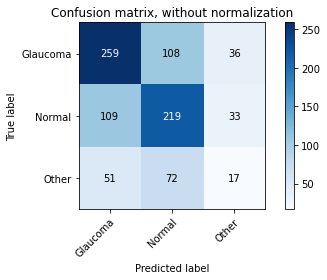

              precision    recall  f1-score   support

    Glaucoma       0.62      0.64      0.63       403
      Normal       0.55      0.61      0.58       361
       Other       0.20      0.12      0.15       140

    accuracy                           0.55       904
   macro avg       0.45      0.46      0.45       904
weighted avg       0.53      0.55      0.53       904

Specificity
Glaucoma: 0.68
Normal: 0.67
Other: 0.91


In [15]:
y_pred = bestModel["svm"].predict(X_test)
plot_confusion_matrix(y_test,y_pred, classes=classes_list,title='Confusion matrix, without normalization')